# NLP and Sentiment Analysis based Trading Strategy

In this case study we use NLP to build a trading strategy.

Reference: Tatsat, Hariom, Sahil Puri, and Brad Lookabaugh. Machine Learning and Data Science Blueprints for Finance. O'Reilly Media, 2020.

<a id='1'></a>
# 1. Problem Statement

The problem statement is to build a trading strategy that uses NLP to extracts the information inside the news headlines, assigns a sentiment to that and use the sentiments and the information inside the news headlines for a trading strategy.

The data used for this case study will be from three sources:
* **News headlines data compiled from RSS feeds of several news websites**: This news headlines data is complied by different news website and contains the most financially relevant news filtered by human editors. For the purpose of this study, we will only look at the headline, not the details in the story. Another important characteristic of this dataset is that the relevant tickers in the story are extracted. Our dataset contains 82,643 headlines from to 2011-05-02 to 2018-12-28
* **Yahoo finance website for the stock return:** (The return data can be obtained from other website such as yahoo finance)

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages


<a id='2.1'></a>
## 2.1. Loading the python packages

As a first step we check if the additional packages needed are present, if not install them. These are checked separately as they aren't included in requirement.txt as they aren't used for all case studies.

In [11]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'nltk', 'spacy', 'textblob', 'backtrader'}
missing = required - installedPackages
if missing:
    !pip3 install nltk==3.4
    !pip3 install textblob==0.15.3
    !pip3 install -U SpaCy
    !python3 -m spacy download en_core_web_lg
    !pip3 install backtrader==1.9.74.123    

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.9 MB/s eta 0:00:0000:0100:04

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Devel

Let us load the libraries

In [12]:
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

# nlp = spacy.load('en_core_web_sm')
!python -m spacy download en_core_web_md 
# import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from tensorflow.keras.layers import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

#Additional Libraries 
import json  
import zipfile
import os.path
import sys

zsh:1: command not found: python


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/xiang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2.2'></a>
## 2.2. Loading the stock price data

The stock price data is loaded in this step from Yahoo Finance in this step. The loaded data is saved in csv for further use.

In [23]:
tickers = ['AAPL','MSFT','AMZN','GOOG','WMT','JPM','TSLA','NFLX','ADBE']
start = '2010-01-01'
end = '2018-12-31'
df_ticker_return = pd.DataFrame()
for ticker in tickers:    
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start = start, end = end)
        df_ticker_return['ticker']= ticker 
    else:
        data_temp = ticker_yf.history(start = start, end = end)
        data_temp['ticker']= ticker 
        df_ticker_return = pd.concat([df_ticker_return, data_temp])
df_ticker_return.to_csv(r'Data/Step2.2_ReturnData.csv')

Let us look at the details of the data

In [24]:
df_ticker_return.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-01-04 00:00:00-05:00,6.453206,6.485558,6.421458,6.470742,493729600,0.0,0.0,AAPL
2010-01-05 00:00:00-05:00,6.488580,6.518514,6.447762,6.481928,601904800,0.0,0.0,AAPL


The data contains the tickers and their return. In this next step, we clean the data make sure that the starting point is 2010 and the NAs in the data are dropped. Let us look at the news data now.

<a id='3'></a>
# 3. Data Preparation

We divide the data preparation into couple of steps as follows:
* Loading and preprocessing the news data
* Preparing the combined data

<a id='3.1'></a>
## 3.1 Loading and preprocessing News Data

The news data is downloaded from the News RSS feed and the file is downloaded in the json format and the json files for different dates are kept under a zipped folder. 

Let us see the content of the json file

In [25]:
z = zipfile.ZipFile("Data/Raw Headline Data.zip", "r")
testFile=z.namelist()[10]
fileData= z.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:500]  
fileDataSample

'li class="n-box-item date-title" data-end="1305172799" data-start="1305086400" data-txt="Tuesday, December 17, 2019">Wednesday, May 11, 2011</li><li class="n-box-item sa-box-item" data-id="76179" data-ts="1305149244"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/CSCO" target="_blank">CSCO</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/76179" sasource="on_the_move_news_fidelity" target="_blank">Cisco (NASDAQ:CSCO): Pr'

As we can see that the json format is not suitable for the algorithm. We need to get the news from the jsons and the following function is used for it. Regex becomes the vital part of this step. Regex can find a pattern in the raw, messy text and perform actions accordingly.

In [26]:
#This function performs the json parsing given the 
def jsonParser(json_data): 
    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
    return main_tickers, final_headlines

In [27]:
jsonParser(json.loads(fileData))[1][1]

'Cisco Systems (NASDAQ:CSCO) falls further into the red on FQ4 guidance of $0.37-0.39 vs. $0.42 Street consensus. Sales seen flat to +2% vs. 8% Street view. CSCO recently -2.1%.'

As we can see that using the json parser the news headlines are extracted from the complex html format. This format is good enough to be used for further analysis.

Now, we extract the ticker and the headlines from all the json files and put it in a dataframe. 

In [28]:
data = None 
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("Data/Raw Headline Data.zip", "r") as z:
    for filename in z.namelist(): 
        #print(filename)
        try:               
            #print('Running {}'.format(filename))
            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                #Step 1: Parse the News Jsons 
                main_tickers, final_headlines = jsonParser(json_data) 
                if len(final_headlines) != json_data['count']:
                    continue
                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)
                           }
                df_f = pd.DataFrame(df_dict)            
                data_df_news.append(df_f)            
        except:
            pass  

Let us look at the content of the data

In [29]:
data_df_news=pd.concat(data_df_news)
data_df_news.head(2)

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02


As we can see the data has the ticker, headlines and the date which will be used in the next step for combining with the return.

<a id='3.2'></a>
## 3.2 Preparing the combined data

In this step we extract the event return, which is the return that corresponds to
the event. We do this because at times the news is reported late and at other times it is
reported after market close. Having a slightly wider window ensures that we capture
the essence of the event. Event return in defined as follows:
$ R_{t-1} + R_t + R_{t+1} $

Where, $ R_{t-1} $, $ R_{t+1} $ are the return before and after the news data and $ R_{t} $ is the return on
the day of the news (i.e. time t)

In [30]:
#Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()
#Computing the event return
df_ticker_return['eventRet'] = df_ticker_return['ret_curr'] + df_ticker_return['ret_curr'].shift(-1) + df_ticker_return['ret_curr'].shift(1)
df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

Now we have all the data in place we will prepare a combined dataframe which will have the news headlines mapped to the date, event Return and stock ticker. This dataframe will be used for further analysis for sentiment analysis model and for building the trading strategy.

In [31]:
combinedDataFrame = pd.merge(data_df_news, df_ticker_return, how='left', left_on=['date','ticker'], right_on=['date','ticker'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['ticker'].isin(tickers)]
data_df = combinedDataFrame[['ticker','headline','date','eventRet','Close']]
data_df = data_df.dropna()

In [32]:
data_df.head(2)

,ticker,headline,date,eventRet,Close
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285


Let us save the data in a csv file to be used later, so that the data processing step can be skipped everytime we are looking into analysis. 

In [33]:
data_df.dropna().to_csv(r'Data\Step3_NewsAndReturnData.csv', sep='|', index=False)

<a id='3.3'></a>
## 3.3 Loading the preprocessed data
#### Start from this step in case you dont want to run the previous preprocessing steps

In [34]:
data_df = pd.read_csv(r'Data\Step3_NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()

In [35]:
print(data_df.shape, data_df.ticker.unique().shape)

(2454, 5) (9,)


In this step, we prepared a clean dataframe that has ticker, headline, event return, return for a given day and future return for 9 unique stock tickers with total 2454 rows of data.

<a id='4'></a>
# 4 Evaluate Models for Sentiment Analysis

In this section we will go through following two different approaches of getting the sentiments for the news which we will use for building the trading strategy.

* Predefined model-TextBlob package
* Tuned Model-Classification algorithms and LSTM

We will also explore the difference between different ways of performing the sentiment analysis. Let us go through the steps. 

<a id='4.1'></a>
## 4.1 - Predefined model-TextBlob package

The texblob sentiment function is pretrained model based on Naïve-Bayes classification algorithm to convert a sentence to a numerical value of sentiment between -1 to +1 and map adjectives frequently found in movie reviews(source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) to sentiment polarity scores, ranging from -1 to +1 (negative ↔ positive) and a similar subjectivity score (objective ↔ subjective). We apply this on all headline articles. Let us compute the sentiment for all the headlines in the data

In [36]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

In [37]:
TextBlob(text1).sentiment.polarity

0.5

The sentiment polarity is a number between -1 (Very Negative) and +1 (Very Positive). We apply this on all headline we have in the data processed in the previous step. Let us compute the sentiment for all the headlines in the data

In [38]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 

Let us analyse the scatterplot of the sentiments and the return.

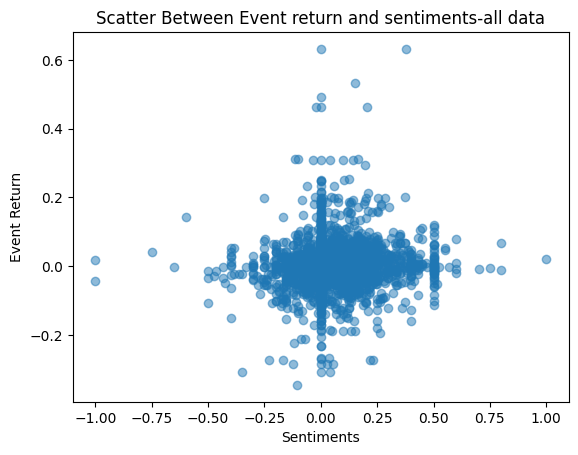

In [39]:
plt.scatter(data_df['sentiment_textblob'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [40]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.06646047003898944


The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high.  

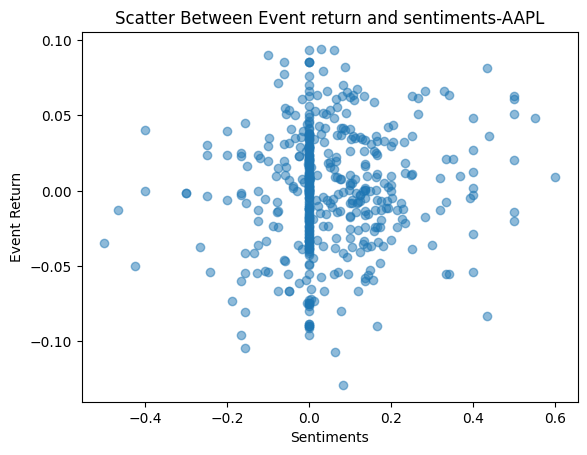

In [41]:
# Question: give a scatter plot to reveal the relationship between event return and sentiments for AAPL and provide some observations
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Observations:
Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centred around 0. 

<a id='4.2'></a>
## 4.2 - Supervised Learning-Classification algorithms and LSTM

In this step, we develop customised model for sentiment analysis, based on available labelled data. The label data for this is obtained from kaggle website. Let us look at the data.

In [42]:
sentiments_data = pd.read_csv(r'Data/LabelledNewsData.csv',encoding = "ISO-8859-1")

In [43]:
sentiments_data.head(1)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0


In [44]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


The data has headlines for the news across 30 different stocks, with total 9470 rows, and has sentiments labelled 0 and 1. The headlines are already in almost cleaned. In order to run a supervised learning model, we first need to convert the news headlines into feature representation. 

In [47]:
#word-embedding
all_vectors = np.array([np.array([token.vector for token in nlp(s)]).mean(axis=0) for s in sentiments_data['headline']])
all_vectors.shape

(9470, 96)

Now that we have prepared the independent variable we train the classification model. We first divide the data into training set and test set and futher run the key classification models. 

In [48]:
# split out validation dataset for the end
Y= sentiments_data["sentiment"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
#Neural Network
models.append(('NN', MLPClassifier()))
# Question: add a k-nearest neighbors model and compare it with the NN model
models.append(('KNN', KNeighborsClassifier()))

Running all the classification models

In [49]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))

NN: 0.804947 (0.012799) 0.978277 0.800774
[[ 934  266]
 [ 300 1341]]
KNN: 0.745813 (0.021252) 0.842058 0.746920
[[ 845  330]
 [ 389 1277]]


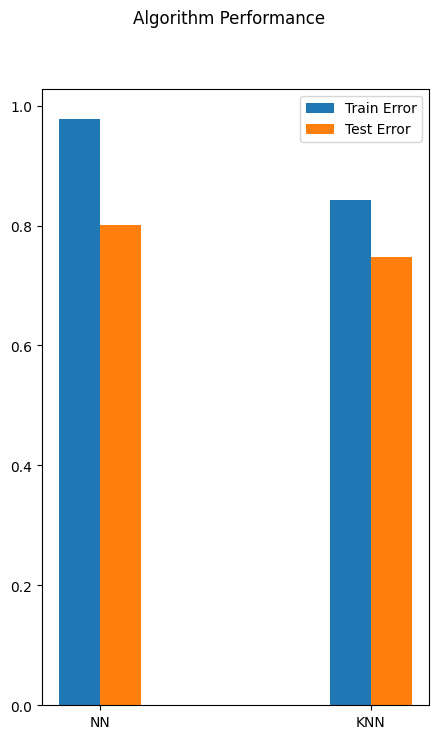

In [50]:
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.15  # the width of the bars
fig.suptitle('Algorithm Performance')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(5,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

### LSTM based model

For NLP, RNN based model are preferred over other machine learning models as RNN stores the information for current feature as well neighboring features for prediction. 

In [51]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)

Dividing the data into the training and test set. 

In [52]:
Y_LSTM = sentiments_data["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, \
                       Y_LSTM, test_size=validation_size, random_state=seed)

In the following code snippet, we used Keras library to build a neural network classifier.

In [53]:
from keras.wrappers.scikit_learn import KerasClassifier
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model    
model_LSTM = KerasClassifier(build_fn=create_model, epochs=3, verbose=1, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

Epoch 1/3
125/125 [==============================] - 12s 91ms/step - loss: 0.3540 - accuracy: 0.8293 - val_loss: 0.1015 - val_accuracy: 0.9653
Epoch 2/3
125/125 [==============================] - 11s 89ms/step - loss: 0.0397 - accuracy: 0.9887 - val_loss: 0.0818 - val_accuracy: 0.9702
Epoch 3/3
125/125 [==============================] - 11s 88ms/step - loss: 0.0131 - accuracy: 0.9972 - val_loss: 0.0721 - val_accuracy: 0.9744


In [54]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

89/89 [==============================] - 1s 15ms/step


Computing the accuracy and confusion metrics. 

In [55]:
print(train_result_LSTM,test_result_LSTM)

0.9889877809624378 0.9693769799366421


As expected, the LSTM model has the better performance in the test set as compared to all other models that we saw before. Let us use LSTM model for the computation of the sentiments in the data. 

In [56]:
sequences_LSTM = tokenizer.texts_to_sequences(data_df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)

In [57]:
Y_LSTM = model_LSTM.predict(X_LSTM)

77/77 [==============================] - 1s 15ms/step


In [58]:
data_df['sentiment_LSTM'] = Y_LSTM 

In [59]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_LSTM'])
print(corrlation)

0.13473576054908334


<a id='5'></a>
# 5. Model Evaluation- Building a Trading Strategy

The sentiment data can be used in different ways for the trading strategy. Sentiment scores can be used as a directional signal and ideally create a long-short portfolio, by buying the stocks with positive score and selling the stocks with negative score. The sentiments can also be used as additional features over and above other features(such as correlated stocks, technical indicators) in a supervised learning model to predict the price or come up with a trading strategy. 

In the trading strategy in this case study we buy and sell stock as per the current stock sentiments : 
* Buy a stock when the change in sentiment score (Current sentiment score - previous sentiment score) is greater than .5 and sell a stock when the change in sentiment score is less than -.5.
* Additionally, we check for 15 days moving average while buying and selling and buy or sell in a unit of 100. 

Obviously, there can be many ways to create the trading strategy based in sentiments, by varying the threshold, or changing the number of units based on the initial cash available.

We use lexicon based sentiments for the trading strategy.


<a id='5.1'></a>
## 5.1. Setting up the strategy 
Here we use backtrader which is a Python based API for writing and backtesting trading strategy. Backtrader allows you to focus on writing reusable trading strategies, indicators and analyzers instead of having to spend time building infrastructure. we have a convenient framework to backtest and write our trading strategy. We used the Quickstart code in the docs (i.e. Refer to https://www.backtrader.com/docu/quickstart/quickstart/) as a base and modified it to include the sentiment scores.

We imlement a simple strategy to buy if the previous day’s sentiment score increases by 0.5 from the last day and sell if it decreases by 0.5.


The following function contains two classes: 
* Sentiment:
* SentimentStrat: The "next" function of this class implements the actual trading strategy. 


In [60]:
data_df = pd.read_csv(r'Data/Step4_DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

In [61]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment        
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False
        
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return       
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f BUY CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f SELL CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)   



### Function for running the trading strategy

Now, we write a generic function to run the strategy for any stock. We specified the “ticker” stock feeds to be pulled from Yahoo Finance, set an initial amount of $100,000, a fixed size of 100 lots per trade.

In [62]:
def run_strategy(ticker, start, end):   
    ticker = yf.Ticker(ticker)
    df_ticker = ticker.history(start = start, end = end)
    
    cerebro = bt.Cerebro()
    # Add the data
    cerebro.addstrategy(SentimentStrat)        
    data = bt.feeds.PandasData(dataname=df_ticker)
    cerebro.adddata(data)  
    start = 100000.0
    cerebro.broker.setcash(start)   
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    print('Starting Portfolio Value: %.2f' % start)    
    cerebro.run() 
#     cerebro.plot(volume=False, iplot=True, plotname= ticker)
    end = cerebro.broker.getvalue()
    print('Start Portfolio value: %.2f\nFinal Portfolio Value: %.2f\nProfit: %.2f\n' \
          % (start, end, end - start))
    return float(df_ticker['Close'][0]), (end - start)

<a id='5.2'></a>
## 5.2. Results for Individual Stocks

First running the strategy for google

In [63]:
ticker = 'GOOG'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')
# running the strategy for APPL. Hint: create a new ticker variable
# ticker = 'AAPL'

Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 16.21
2012-04-13, BUY EXECUTED, Price: 16.13, Cost: 1612.83, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 17.31
2012-10-19, SELL EXECUTED, Price: 17.57, Cost: 1612.83, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 144.53, NET 144.53
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 18.47
2013-01-11, BUY EXECUTED, Price: 18.48, Cost: 1848.07, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 28.61
2014-07-18, SELL EXECUTED, Price: 29.57, Cost: 1848.07, Comm 0.00
2014-07-18, OPERATION PROFIT, GROSS 1108.81, NET 1108.81
2014-07-18, Previous Sentiment -0.22, New Sentiment 0.77 BUY CREATE, 29.67
2014-07-21, BUY EXECUTED, Price: 29.51, Cost: 2950.65, Comm 0.00
2014-09-12, Previous Sentiment 0.66, New Sentiment -0.05 SELL CREATE, 28.70
2014-09-15, SELL EXECUTED, Price: 28.57, Cost: 2950.65, Comm 0.00
2014-09-1

(16.573129653930664, 2485.9493255615234)

The results show an overall profit of 49719.00.

Now we choose one of the days on which buy was triggered and we look at the news on that data and previous day.

In [64]:
GOOG_ticker= data_df[data_df['ticker'].isin([ticker])]
New= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-17']['headline'])
Old= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-16']['headline'])
print("Current News:",New,"\n\n","Previous News:", Old)

Current News: ["Axiom Securities has upgraded Google (GOOG +13.4%, GOOGL +14.8%) to Buy following the company's Q2 beat and investor-pleasing comments about spending discipline, potential capital returns, and YouTube/mobile growth. MKM has launched coverage at Buy, and plenty of other firms have hiked their targets. Google's market cap is now above $450B."] 

 Previous News: ["While Google's (GOOG, GOOGL) Q2 revenue slightly missed estimates when factoring traffic acquisitions costs (TAC), its ex-TAC revenue of $14.35B was slightly above a $14.3B consensus. The reason: TAC fell to 21% of ad revenue from Q1's 22% and Q2 2014's 23%. That also, of course, helped EPS beat estimates.", 'Google (NASDAQ:GOOG): Q2 EPS of $6.99 beats by $0.28.']
